# Explore chatbot vs. human dialog detection via unsupervised learning approach

In [2]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
import pickle
import numpy as np
from sklearn import metrics

Using TensorFlow backend.


In [21]:
file_name = 'data/x_r_full_tur4_shuf.pkl'
file_obj = open(file_name,'rb') 
x_vec = pickle.load(file_obj)   
file_obj.close()
file_name = 'data/y_in_tur4_shuf.pkl'
file_obj = open(file_name,'rb') 
y_in_vec = pickle.load(file_obj)   
file_obj.close()
file_name = 'data/y_tar_tur4_shuf.pkl'
file_obj = open(file_name,'rb') 
y_tar_vec = pickle.load(file_obj)   
file_obj.close()

In [22]:
# input vector for autoencoder is concatenation of input and output sides of dialog including human and bot responses 
auto_x = []
for i in range(len(x_vec)):
    row1 = x_vec[i].reshape(3000,).tolist()
    row2 = y_in_vec[i].reshape(3050,).tolist()
    row = row1 + row2
    auto_x.append(row)
auto_x = np.asarray(auto_x)

In [23]:
# input vector: 50 element GLoVe encoded words, 60 word max initiating sequence, 61 word max response sequence (with stop word)
auto_x.shape

(40000, 6050)

In [24]:
# Classification: 0 = 'human', 1 = 'chatbot'
x_class = y_tar_vec[:,0]

In [25]:
file_name = 'data/auto_x_tr4.pkl'
file_obj = open(file_name,'wb') 
pickle.dump(auto_x, file_obj)   
file_obj.close()
file_name = 'data/x_class_auto_tr4.pkl'
file_obj = open(file_name,'wb') 
pickle.dump(x_class, file_obj)   
file_obj.close()

In [3]:
file_name = 'data/auto_x_tr4.pkl'
file_obj = open(file_name,'rb') 
auto_x = pickle.load(file_obj)   
file_obj.close()
file_name = 'data/x_class_auto_tr4.pkl'
file_obj = open(file_name,'rb') 
x_class = pickle.load(file_obj)   
file_obj.close()

In [26]:
del x_vec, y_in_vec, y_tar_vec

In [6]:
batch_size = 64
epochs = 8  # based on validation loss, early stopping at 8 epochs prevents overfit

In [7]:
# Autoencoder model
input_data = Input(shape=(6050,))
encoded = Dense(512, activation='relu')(input_data)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(512, activation='relu')(encoded)
decoded = Dense(6050, activation='sigmoid')(decoded)

In [8]:
autoencoder = Model(input_data, decoded)
encoder = Model(input_data, encoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

autoencoder.fit(auto_x, auto_x,
                batch_size=batch_size, epochs=epochs, validation_split = 0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/8
32000/32000 [==============================] - 110s - loss: 0.0809 - acc: 0.0610 - val_loss: 0.0745 - val_acc: 0.0681
Epoch 2/8
32000/32000 [==============================] - 112s - loss: 0.0726 - acc: 0.0772 - val_loss: 0.0724 - val_acc: 0.0776
Epoch 3/8
32000/32000 [==============================] - 108s - loss: 0.0716 - acc: 0.0812 - val_loss: 0.0720 - val_acc: 0.0809
Epoch 4/8
32000/32000 [==============================] - 109s - loss: 0.0711 - acc: 0.0806 - val_loss: 0.0717 - val_acc: 0.0789
Epoch 5/8
32000/32000 [==============================] - 109s - loss: 0.0708 - acc: 0.0798 - val_loss: 0.0716 - val_acc: 0.0834
Epoch 6/8
32000/32000 [==============================] - 107s - loss: 0.0706 - acc: 0.0815 - val_loss: 0.0714 - val_acc: 0.0798
Epoch 7/8
32000/32000 [==============================] - 107s - loss: 0.0705 - acc: 0.0792 - val_loss: 0.0714 - val_acc: 0.0796
Epoch 8/8
32000/32000 [==============================] 

In [31]:
autoencoder.save('data/autoenc.h5')

In [4]:
autoencoder = load_model('data/autoenc.h5')

In [9]:
# use autoencoder to encode 6050 input vectors to 32-dimension space
encoded_x = encoder.predict(auto_x)

In [10]:
del auto_x

In [11]:
# use t-SNE embedding for 2D visualization of autoencoded properties
from sklearn.manifold import TSNE
x_2d = TSNE(n_components=2).fit_transform(encoded_x[:8000])

In [12]:
file_name = 'data/auto_enc_x_tr4.pkl'
file_obj = open(file_name,'wb') 
pickle.dump(encoded_x, file_obj)   
file_obj.close()
file_name = 'data/x_2d_tsne_tr4.pkl'
file_obj = open(file_name,'wb') 
pickle.dump(x_2d, file_obj)   
file_obj.close()

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
x_2d_h = []
x_2d_b = []
for i in range(8000):
    if x_class[i] == 0:
        x_2d_h.append(x_2d[i])
    else:
        x_2d_b.append(x_2d[i])
x_2d_h = np.asarray(x_2d_h)
x_2d_b = np.asarray(x_2d_b)

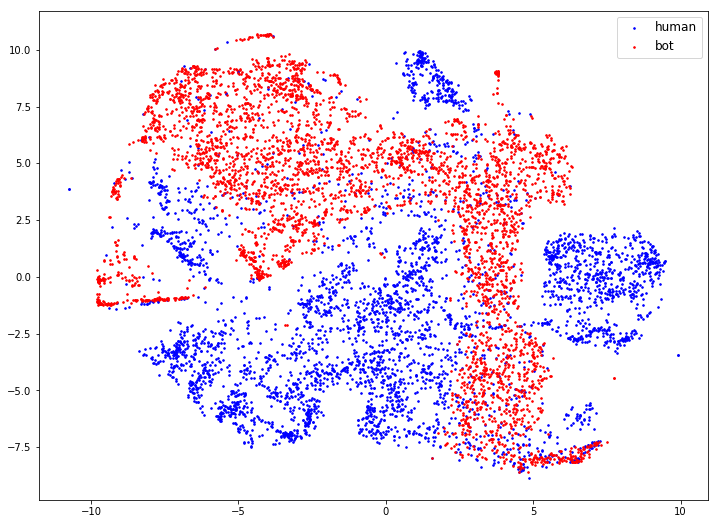

In [30]:
fig = plt.figure(figsize = [12,9])
ax = fig.add_subplot(1,1,1)
ax.scatter(x_2d_h[:, 0], x_2d_h[:, 1], color='blue', s=2.5, label='human')
ax.scatter(x_2d_b[:, 0], x_2d_b[:, 1], color='red', s=2.5, label='bot')
#ax.title('t-SNE 2D visualization of autoencoder embedding')
ax.legend(loc='upper right', fontsize=12)
plt.show()

### 2D projection of autoencoded data shows reasonable discrimination between human and chatbot responses via unsupervised learning.  Discrimination in 32D space may also me more refined.  Encoded/reduced dimensionality representation may be a useful basis for classification.

In [31]:
# load test data and reformat for use by autoencoder
file_name = 'data/x_r_full_ts_tur4_shuf.pkl'
file_obj = open(file_name,'rb') 
x_vec = pickle.load(file_obj)   
file_obj.close()
file_name = 'data/y_in_ts_tur4_shuf.pkl'
file_obj = open(file_name,'rb') 
y_in_vec = pickle.load(file_obj)   
file_obj.close()
file_name = 'data/y_tar_ts_tur4_shuf.pkl'
file_obj = open(file_name,'rb') 
y_tar_vec = pickle.load(file_obj)   
file_obj.close()

In [32]:
auto_x_ts = []
for i in range(len(x_vec)):
    row1 = x_vec[i].reshape(3000,).tolist()
    row2 = y_in_vec[i].reshape(3050,).tolist()
    row = row1 + row2
    auto_x_ts.append(row)
auto_x_ts = np.asarray(auto_x_ts)

In [33]:
x_class_ts = y_tar_vec[:,0]

In [34]:
file_name = 'data/auto_x_ts4.pkl'
file_obj = open(file_name,'wb') 
pickle.dump(auto_x_ts, file_obj)   
file_obj.close()
file_name = 'data/x_class_auto_ts4.pkl'
file_obj = open(file_name,'wb') 
pickle.dump(x_class_ts, file_obj)   
file_obj.close()

In [35]:
encoded_x_ts = encoder.predict(auto_x_ts)

In [36]:
del auto_x_ts

In [40]:
file_name = 'data/auto_enc_x_ts4.pkl'
file_obj = open(file_name,'wb') 
pickle.dump(encoded_x_ts, file_obj)   
file_obj.close()

### Use k-nearest neighbors classifer as an example of classificaiton capabilities against encoded space

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [43]:
# Search for appropriate k value using 10-fold cross-validation
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, encoded_x, x_class, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.93337500000000007, 0.95277500000000015, 0.95107500000000011, 0.96057500000000007, 0.94925000000000015, 0.95712500000000011, 0.94789999999999996, 0.95382500000000014, 0.94569999999999987, 0.95062499999999994, 0.94352499999999995, 0.94767500000000005, 0.942075, 0.94572500000000004, 0.9406000000000001, 0.94347499999999995, 0.93857499999999994, 0.94142499999999996, 0.93712499999999999, 0.93977500000000003, 0.935975, 0.93825000000000003, 0.93417499999999998, 0.93692500000000012, 0.93310000000000015, 0.93564999999999987, 0.93157500000000015, 0.93387500000000012, 0.93025000000000002, 0.93254999999999999]


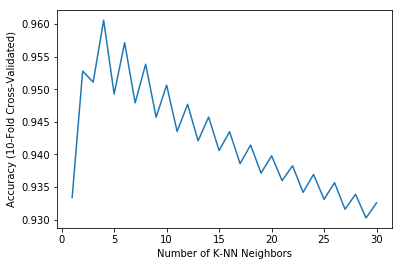

In [44]:
plt.plot(k_range, k_scores)
plt.xlabel('Number of K-NN Neighbors')
plt.ylabel('Accuracy (10-Fold Cross-Validated)')

**4 nearest neighbors yield's 96% cross-validated accuracy on training data**  
(sawtooth plot pattern typical of KNN minority inclusion effects odd-to-even)

In [45]:
# Apply to test data
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(encoded_x, x_class)
y_pred = knn.predict(encoded_x_ts)

In [46]:
# evaluate metrics: confusion metrics, recall, precision, F1 score
confusion = metrics.confusion_matrix(x_class_ts, y_pred)
recall = metrics.recall_score(x_class_ts, y_pred)
precision = metrics.precision_score(x_class_ts, y_pred)
F1 = metrics.f1_score(x_class_ts, y_pred)

In [47]:
print('Confusion Matrix:')
print(confusion)
print()
print('Recall: {:8.3f}'.format(recall))
print('Precision: {:5.3f}'.format(precision))
print('F1 score: {:6.3f}'.format(F1))

Confusion Matrix:
[[18582  1398]
 [  130 19890]]

Recall:    0.994
Precision: 0.934
F1 score:  0.963


### Test scores for classification against encoded data are not as high as for encoder-decoder Turing test model; however, autoencoder training is unsupervised and may be extensible to problems of bot identification where large volumes of validated class data is scarce.